# 군집화 과제
## 와인 데이터셋 개요

사이킷런(Scikit-learn)의 와인 데이터셋은 이탈리아에서 생산된 동일 지역의 세 가지 다른 와인 종류(class)에 대한 화학적 분석 결과를 담고 있습니다. 각 와인 샘플에는 13개의 연속형 특성(feature)이 포함되어 있으며, 이는 와인의 다양한 화학적 성분을 나타냅니다.

## 데이터셋의 주요 특성

데이터 크기: 총 178개의 샘플(와인)로 구성되어 있습니다.

특성(Features): 13개의 수치형 특성이 있습니다. 이 특성들은 와인의 화학적 성분과 관련이 있으며, 다음과 같습니다.

| 칼럼 명 | 데이터 타입 | 설명 |
|:--- |:--- |:---|
| **alcohol** | `float64` | 와인의 알코올 함량 |
| **malic_acid** | `float64` | 와인의 말산 함량 |
| **ash** | `float64` | 와인의 재(ash) 함량 |
| **alcalinity_of_ash** | `float64` | 재의 알칼리성 |
| **magnesium** | `float64` | 마그네슘 함량 |
| **total_phenols** | `float64` | 총 페놀 함량 |
| **flavanoids** | `float64` | 플라보노이드 함량 |
| **nonflavanoid_phenols** | `float64` | 비(非)플라보노이드 페놀 함량 |
| **proanthocyanins** | `float64` | 프로안토시아닌 함량 |
| **color_intensity** | `float64` | 와인의 색상 강도 |
| **hue** | `float64` | 와인의 색조 |
| **od280/od315_of_diluted_wines** | `float64` | 희석된 와인의 $\text{OD}_{280}/\text{OD}_{315}$ 비율 |
| **proline** | `float64` | 프롤린 함량 |
| **class** | `int64` | 와인의 종류 (타겟 변수) |

타겟 변수(Target): 세 가지 와인 종류를 나타내는 레이블(label)이 포함되어 있습니다. -> 군집화 결과 비교 시 사용!

# 0. 라이브러리 임포트 및 데이터 전처리

In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

# 데이터 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 스케일링 관련 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 군집화 관련 라이브러리
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan import HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment


In [3]:
# 한글 폰트 안깨지게 설정
import platform

def set_korean_font():
    """
    운영체제에 맞는 한글 폰트를 설정합니다.
    """
    os_name = platform.system()
    
    if os_name == 'Windows':
        font_name = 'Malgun Gothic'
    elif os_name == 'Darwin': # macOS
        font_name = 'AppleGothic'

    # 전역으로 폰트 설정
    plt.rc('font', family=font_name)
    
    # 마이너스 부호 깨짐 방지 설정
    plt.rc('axes', unicode_minus=False)
    
    print(f"'{font_name}' 폰트로 설정되었습니다.")

set_korean_font()

import warnings
warnings.filterwarnings('ignore')

'Malgun Gothic' 폰트로 설정되었습니다.


던 인덱스 계산을 위한 함수까지 미리 만들어둡니다!

In [4]:
def calculate_dunn_index(X, labels):
    """
    Dunn Index 계산 (개선된 버전)
    Dunn Index = min(군집 간 거리) / max(군집 내 거리)
    높을수록 좋은 군집화
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        return 0
    
    # 군집별 중심점 계산 (한 번만)
    centroids = {}
    cluster_points = {}
    
    for label in unique_labels:
        mask = labels == label
        points = X[mask]
        cluster_points[label] = points
        centroids[label] = points.mean(axis=0)
    
    # 군집 간 최소 거리 (중심점 간 거리로 근사)
    min_inter_distance = float('inf')
    centroid_list = list(centroids.values())
    
    for i in range(len(centroid_list)):
        for j in range(i+1, len(centroid_list)):
            distance = np.linalg.norm(centroid_list[i] - centroid_list[j])
            min_inter_distance = min(min_inter_distance, distance)
    
    # 군집 내 최대 거리 (각 군집의 지름)
    max_intra_distance = 0
    
    for points in cluster_points.values():
        if len(points) > 1:
            # 각 군집의 중심점으로부터 가장 먼 두 점의 거리
            centroid = points.mean(axis=0)
            distances = np.linalg.norm(points - centroid, axis=1)
            diameter = 2 * np.max(distances)  # 지름 근사
            max_intra_distance = max(max_intra_distance, diameter)
    
    if max_intra_distance == 0:
        return 0
    
    return min_inter_distance / max_intra_distance

## 데이터 불러오기

In [5]:
from sklearn.datasets import load_wine

wine = load_wine()
data = pd.DataFrame(wine.data, columns=wine.feature_names)

data['class'] = wine.target # 와인의 실제 분류를 담은 칼럼

data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  class

와인의 실제 종류가 군집화의 피처로 들어가면 정보가 당연히 왜곡되겠죠?

와인의 실제 종류를 담고 있는 칼럼을 분리하는 과정입니다.

In [7]:
# 클래스 정보를 실제 이름으로 매핑
class_names = wine.target_names
data['class_name'] = data['class'].map({0: class_names[0], 1: class_names[1], 2: class_names[2]})
print(f"\n클래스별 분포 (이름):")
print(data['class_name'].value_counts())

# 정답 레이블 저장 (나중에 비교용)
true_classes = data['class'].copy()
true_class_names = data['class_name'].copy()

# 군집화에 사용할 특성 선택 (클래스 정보 제외)
features_for_clustering = data.drop(['class', 'class_name'], axis=1)

print(f"\n군집화용 특성(class 계열 칼럼 제외):")
print(features_for_clustering.columns.tolist())


클래스별 분포 (이름):
class_1    71
class_0    59
class_2    48
Name: class_name, dtype: int64

군집화용 특성(class 계열 칼럼 제외):
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


## 스케일링

StandardScaler를 사용해 스케일링을 진행합니다

In [9]:
# 데이터 표준화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_for_clustering)

# 정리된 데이터 저장 (군집화 결과 저장용)
data_clean = features_for_clustering.copy()
data_clean['true_class'] = true_classes
data_clean['true_class_name'] = true_class_names

# 차원 축소

PCA를 사용해 차원 축소를 진행해봅시다!

실제 연구라면 분산을 더 많이 설명할 수 있는 정도로 차원 축소를 하겠지만, 오늘은 시각화의 편의성 등을 위해 2차원으로 차원 축소를 진행할거에요

아래 n_componets에 2를 입력해주세요!

## PCA 적용해 2차원으로 줄이기

In [10]:
# PCA 차원축소 수행
n_components = 2  # 시각화를 위한 2차원

pca = PCA(n_components=n_components, random_state=42)
data_pca = pca.fit_transform(data_scaled)

# PCA 결과 분석
print("="*50)
print("PCA 분석 결과")
print("="*50)
print(f"각 주성분의 설명 분산 비율:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"총 설명 분산: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

# PCA 결과를 DataFrame으로 변환
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

PCA 분석 결과
각 주성분의 설명 분산 비율:
  PC1: 0.3620 (36.20%)
  PC2: 0.1921 (19.21%)
총 설명 분산: 0.5541 (55.41%)


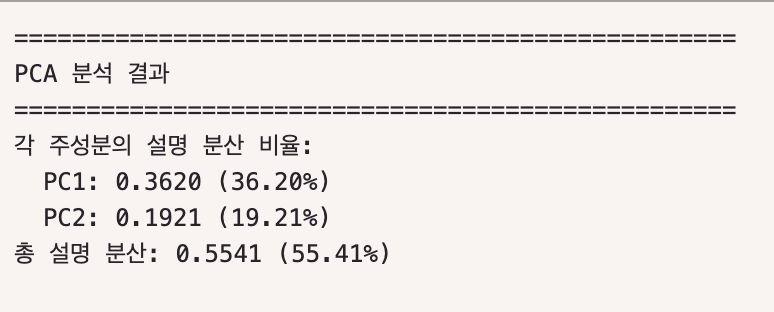

총 13개의 피처를 차원축소를 통해 2차원으로 줄였고, 이를 통해 전체 분산의 55.41%를 설명할 수 있습니다

## PCA 결과 시각화

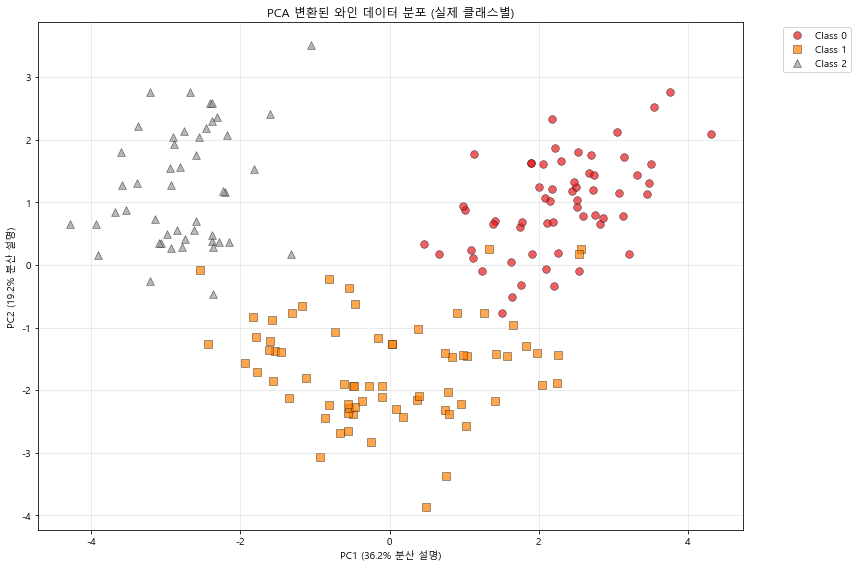

실제 와인 클래스 분포:
  Class 0: 59개 (33.1%)
  Class 1: 71개 (39.9%)
  Class 2: 48개 (27.0%)


In [11]:
# PCA 변환된 데이터 분포 시각화 (실제 와인 클래스)
plt.figure(figsize=(12, 8))

# 각 클래스별로 다른 색상과 마커로 표시 (K-Means 시각화와 동일한 스타일)
unique_classes = np.unique(true_classes)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_classes)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

class_names = ['Class 0', 'Class 1', 'Class 2']  # 또는 wine.target_names 사용 가능

for i, wine_class in enumerate(unique_classes):
    class_mask = true_classes == wine_class
    plt.scatter(data_pca_df.loc[class_mask, 'PC1'], 
                data_pca_df.loc[class_mask, 'PC2'],
                c=[colors[i]], 
                marker=markers[i % len(markers)],
                s=60, 
                alpha=0.7,
                label=f'{class_names[i]}',  # 또는 wine.target_names[i]
                edgecolors='black',
                linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title('PCA 변환된 와인 데이터 분포 (실제 클래스별)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("실제 와인 클래스 분포:")
for i, wine_class in enumerate(unique_classes):
    count = (true_classes == wine_class).sum()
    print(f"  {class_names[i]}: {count}개 ({count/len(true_classes)*100:.1f}%)")

이런 식으로 군집 별로 꽤나 잘 구별이 되어있음을 확인할 수 있습니다.

지금 시각화한 이 실제 와인 데이터의 분포는 추후 서로 다른 군집화 모델을 사용해보고 비교하는 정답지가 될 거에요!

이제 세션에서 배웠던 군집화 알고리즘 4개를 각각 사용하여 군집화를 진행해봅시다

# 군집화 모델 적용
## 1. K-means 모델

### 엘보우 방법 적용해 적절한 k값 찾기

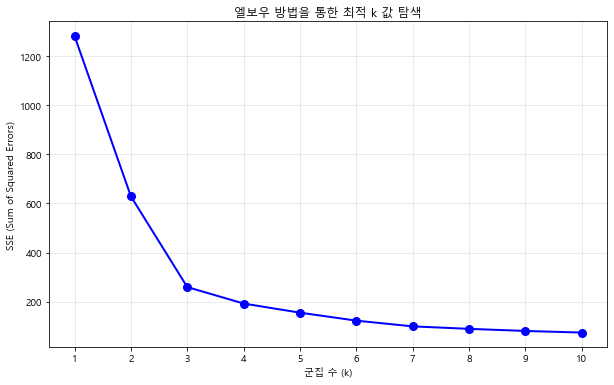

k=1: SSE=1282.10
k=2: SSE=628.79
k=3: SSE=259.51
k=4: SSE=192.39
k=5: SSE=155.19
k=6: SSE=122.71
k=7: SSE=99.39
k=8: SSE=89.29
k=9: SSE=80.74
k=10: SSE=74.16


In [12]:
# 엘보우 방법으로 최적 군집 수 결정 (수정됨)
def find_optimal_clusters_elbow(data, max_k=10):
    inertias = []
    k_range = range(1, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    # 엘보우 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('군집 수 (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.title('엘보우 방법을 통한 최적 k 값 탐색')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_range)
    plt.show()
    
    # 결과 출력
    for k, inertia in zip(k_range, inertias):
        print(f"k={k}: SSE={inertia:.2f}")

# 엘보우 방법 실행 (PC1, PC2만 사용)
find_optimal_clusters_elbow(data_pca_df[['PC1', 'PC2']], max_k=10)

엘보우 방법을 썼을 때, 그래프의 기울기가 가장 크게 변하는 부분인 (*)을 선택하면 됩니다!

In [13]:
# 최적 k 값으로 K-Means 실행
optimal_k = 3  # 엘보우 그래프 결과를 보고 작성하세요!

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans.fit_predict(data_pca_df[['PC1', 'PC2']])

# 군집화 결과 확인
print(f"K-Means 군집화 완료")
print(f"군집 수: {optimal_k}")
print(f"총 데이터 포인트: {len(kmeans_labels)}")

# 군집별 분포
unique_labels, counts = np.unique(kmeans_labels, return_counts=True)
print("\n군집별 데이터 분포:")
for label, count in zip(unique_labels, counts):
    print(f"  군집 {label}: {count}개 ({count/len(kmeans_labels)*100:.1f}%)")

# 결과를 데이터프레임에 추가
data_pca_df['kmeans_cluster'] = kmeans_labels
data_clean['kmeans_cluster'] = kmeans_labels  # data 대신 data_clean 사용

K-Means 군집화 완료
군집 수: 3
총 데이터 포인트: 178

군집별 데이터 분포:
  군집 0: 64개 (36.0%)
  군집 1: 49개 (27.5%)
  군집 2: 65개 (36.5%)


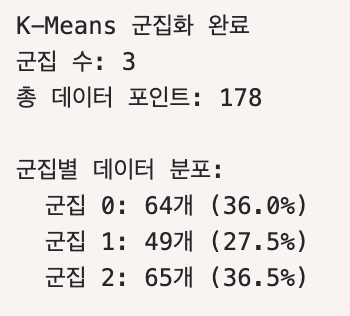

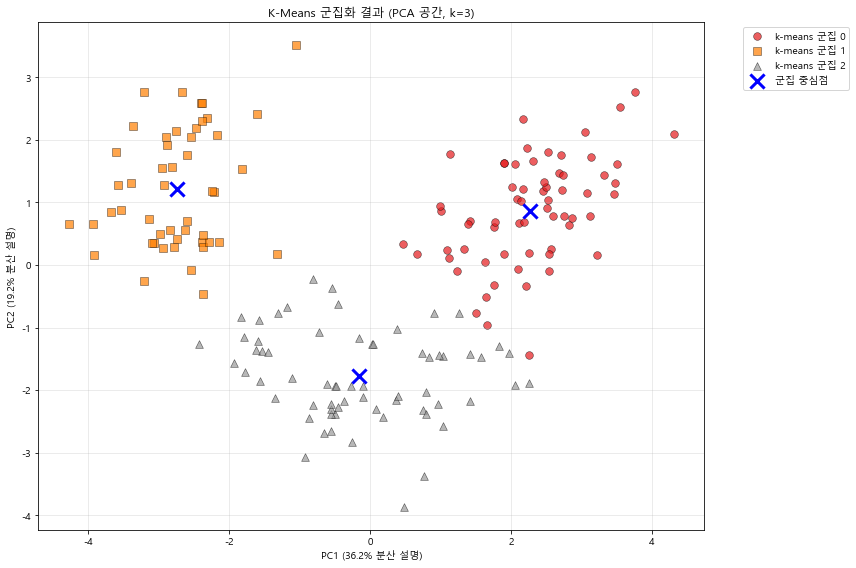

In [14]:
# K-Means PCA 산점도 시각화
plt.figure(figsize=(12, 8))

# 각 군집별로 다른 색상과 마커로 표시
colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    plt.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                data_pca_df.loc[cluster_mask, 'PC2'],
                c=[colors[i]], 
                marker=markers[i % len(markers)],
                s=60, 
                alpha=0.7,
                label=f'k-means 군집 {i}',
                edgecolors='black',
                linewidth=0.5)

# 군집 중심점 표시
centers_pca = kmeans.cluster_centers_
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='b', marker='x', s=200, linewidth=3, 
           label='군집 중심점')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title(f'K-Means 군집화 결과 (PCA 공간, k={optimal_k})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

오... 굉장히 그럴듯한 모양이죠? 그렇다면 성능 평가 지표를 사용해 평가를 해 봅시다

In [15]:
# K-Means 성능 평가
print("="*60)
print("K-Means 군집화 성능 평가")
print("="*60)

# 실루엣 점수
silhouette_kmeans = silhouette_score(data_pca_df[['PC1', 'PC2']], kmeans_labels)
print(f"실루엣 점수 (Silhouette Score): {silhouette_kmeans:.4f}")

# Dunn Index
dunn_kmeans = calculate_dunn_index(data_pca_df[['PC1', 'PC2']].values, kmeans_labels)
print(f"Dunn Index: {dunn_kmeans:.4f}")

K-Means 군집화 성능 평가
실루엣 점수 (Silhouette Score): 0.5611
Dunn Index: 0.6267


뭔가 시각적인 유사성에 비해 실루엣 점수는 그리 높지 않은 것 같아요... 이건 이따 다른 모델까지 보고 생각해봅시다

## 2. DBSCAN 알고리즘 사용하기

k-means에서는 군집의 개수를 직접 정할 수 있었지만, DBSCAN은 군집의 개수를 직접 정할 수 없습니다!

다만 하이퍼파라미터를 조정하면서 군집이 3개로 나타나는 수치는 찾을 수 있습니다.

와인의 종류는 총 3가지였기 때문에, 이를 활용해 3개의 군집으로 구별할 수 있도록 코드를 짜 봅시다!

## 그리드 서치로 군집 3개 되는 하이퍼파라미터 찾기

In [16]:
# 사용자가 원하는 클러스터 개수 지정
target_clusters = 3  # 원하는 클러스터 개수를 여기에 입력

# DBSCAN 목표 클러스터 개수 탐색
def find_dbscan_for_target_clusters(data, target_n_clusters):
    eps_range = np.arange(0.3, 2.0, 0.1)
    min_samples_range = [3, 4, 5, 6, 7, 8, 10, 12]
    
    best_params = None
    min_diff = float('inf')
    best_silhouette = -1
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            diff = abs(n_clusters - target_n_clusters)
            
            # 목표 클러스터 개수와 정확히 일치하거나 가장 가까운 경우
            if diff < min_diff or (diff == min_diff and diff == 0):
                # 실루엣 점수 계산
                if n_clusters > 1:
                    mask = labels != -1
                    if mask.sum() > 1:
                        try:
                            sil_score = silhouette_score(data[mask], labels[mask])
                            if diff < min_diff or (diff == min_diff and sil_score > best_silhouette):
                                min_diff = diff
                                best_silhouette = sil_score
                                best_params = (eps, min_samples, n_clusters, sil_score)
                        except:
                            pass
    
    return best_params

# 최적 파라미터 찾기
result = find_dbscan_for_target_clusters(data_pca_df[['PC1', 'PC2']].values, target_clusters)

if result:
    optimal_eps, optimal_min_samples, found_clusters, sil_score = result
    print(f"목표: {target_clusters}개 클러스터 → 찾은 결과: {found_clusters}개 클러스터")
    print(f"최적 파라미터: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
else:
    optimal_eps, optimal_min_samples = 0.7, 5
    print(f"목표 {target_clusters}개 클러스터에 적합한 파라미터를 찾지 못해 기본값 사용")

목표: 3개 클러스터 → 찾은 결과: 3개 클러스터
최적 파라미터: eps=0.30, min_samples=7


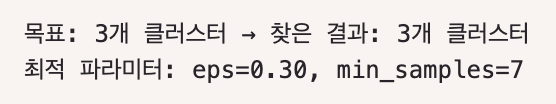

이제 찾은 하이퍼파라미터를 바탕으로 군집화를 돌려봅시다!

In [17]:
# DBSCAN 군집화
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = dbscan_optimal.fit_predict(data_pca_df[['PC1', 'PC2']].values)

# 결과 분석
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)
noise_ratio = n_noise_dbscan / len(dbscan_labels)

print(f"DBSCAN 결과: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
print(f"군집 수: {n_clusters_dbscan}개, 노이즈: {n_noise_dbscan}개 ({noise_ratio*100:.1f}%)")

# 군집별 분포
unique_labels_db, counts_db = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(unique_labels_db, counts_db):
    if label == -1:
        print(f"  노이즈: {count}개")
    else:
        print(f"  군집 {label}: {count}개")

# 결과 저장
data_pca_df['dbscan_cluster'] = dbscan_labels
data_clean['dbscan_cluster'] = dbscan_labels

DBSCAN 결과: eps=0.30, min_samples=7
군집 수: 3개, 노이즈: 147개 (82.6%)
  노이즈: 147개
  군집 0: 9개
  군집 1: 12개
  군집 2: 10개


어... 노이즈가 너무 많죠? 전체의 82.6%를 노이즈로 감지한 것은 모델의 방향성이 잘못되었음을 시사합니다!

대체 어떤 꼴로 군집화를 했길래 이렇게 되는지 확인해봅시다!

## 군집화 결과 시각화하기

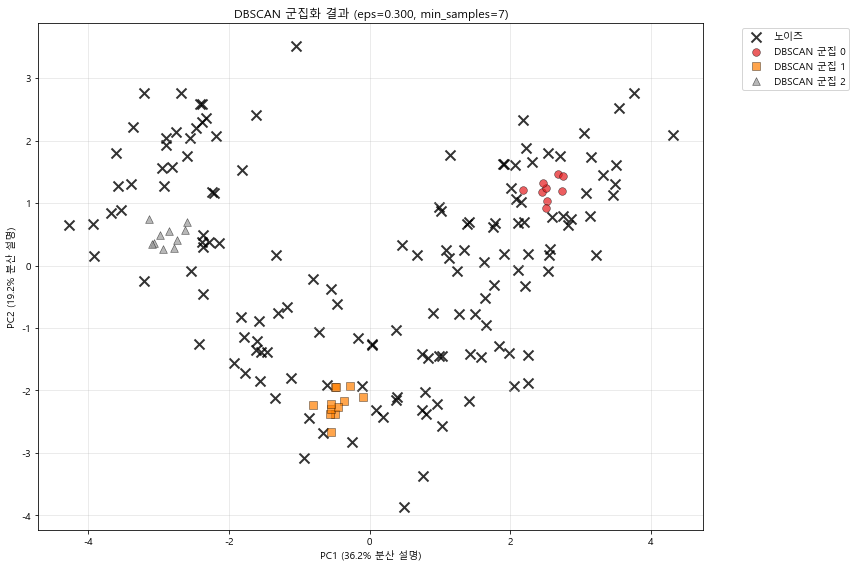

In [18]:
# DBSCAN PCA 산점도 시각화
plt.figure(figsize=(12, 8))

# 노이즈와 군집 구분
mask_noise = dbscan_labels == -1
mask_clusters = dbscan_labels != -1

# 노이즈 포인트 (검은색 X)
if mask_noise.sum() > 0:
    plt.scatter(data_pca_df.loc[mask_noise, 'PC1'], 
                data_pca_df.loc[mask_noise, 'PC2'],
                c='black', marker='x', s=100, alpha=0.8, 
                label='노이즈', linewidth=2)

# 군집 포인트 (색상별)
if mask_clusters.sum() > 0:
    unique_clusters = np.unique(dbscan_labels[mask_clusters])
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
    
    for i, cluster in enumerate(unique_clusters):
        cluster_mask = dbscan_labels == cluster
        plt.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                    data_pca_df.loc[cluster_mask, 'PC2'],
                    c=[colors[i]], 
                    marker=markers[i % len(markers)],
                    s=60, 
                    alpha=0.7,
                    label=f'DBSCAN 군집 {cluster}',
                    edgecolors='black',
                    linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title(f'DBSCAN 군집화 결과 (eps={optimal_eps:.3f}, min_samples={optimal_min_samples})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

너무 많은 정상 데이터까지 노이즈로 감지하면서 모델이 군집화를 잘 하지 못했네요.

그렇다면 실루엣 스코어같은 군집화 성능 평가 지표를 확인해볼까요?

In [19]:
# DBSCAN 성능 평가
print("="*60)
print("DBSCAN 군집화 성능 평가(노이즈 많은 상태)")
print("="*60)

if n_clusters_dbscan > 1 and mask_clusters.sum() > 1:
    # 노이즈 제외하고 성능 평가
    data_for_eval = data_pca_df.values[mask_clusters]
    labels_for_eval = dbscan_labels[mask_clusters]
    
    # 실루엣 점수
    silhouette_dbscan = silhouette_score(data_for_eval, labels_for_eval)
    print(f"실루엣 점수 (Silhouette Score): {silhouette_dbscan:.4f}")
    
    # Dunn Index
    dunn_dbscan = calculate_dunn_index(data_for_eval, labels_for_eval)
    print(f"Dunn Index: {dunn_dbscan:.4f}")
    
    # DBSCAN 고유 메트릭
    print(f"\nDBSCAN 고유 특성:")
    print(f"- 노이즈 탐지율: {n_noise_dbscan/len(dbscan_labels)*100:.1f}%")
    print(f"- 유효 군집 수: {n_clusters_dbscan}개")
    
else:
    print("유효한 군집이 충분하지 않아 성능 평가를 수행할 수 없습니다.")
    silhouette_dbscan = -1
    dunn_dbscan = 0

DBSCAN 군집화 성능 평가(노이즈 많은 상태)
실루엣 점수 (Silhouette Score): 0.9194
Dunn Index: 4.2523

DBSCAN 고유 특성:
- 노이즈 탐지율: 82.6%
- 유효 군집 수: 3개


이상하게도, 군집화 성능 평가 지표인 실루엣 점수와 던 인덱스는 모두 지나치게 높게 나옵니다...

이를 군집화 성능 평가 지표의 특성과 연관지어, 이유를 아래 마크다운 셀에 각자 나름대로 작성해주세요!

## 군집화 결과와 군집화 평가 지표 결과에 차이가 나타나는 이유

너무 많은 노이즈를 제외해 버렸기 때문에, DBSCAN 군집에 포함된 소수의 데이터 포인트들을 가지고 평가 지표를 계산하게 된다.  
-> 계산에 쓰는 포인트가 적고 몰려있기 때문에, 분리도, 응집도가 좋은 지수로 나타난다.  
일종의 과적합같은 느낌..?

## DBSCAN 알고리즘 2(노이즈 최소화 버전)

아까는 그리드서치에서 단순하게 클러스터 수만 정해줬었는데요.

이번에는 노이즈 수를 최소화하면서 군집 수는 3개로 만드는 하이퍼파라미터를 찾아봅시다!

In [21]:
# 사용자가 원하는 클러스터 개수 지정
target_clusters = 3  # 원하는 클러스터 개수를 여기에 입력

# DBSCAN 목표 클러스터 + 노이즈 최소화 탐색
def find_optimal_dbscan(data, target_n_clusters, max_noise_ratio=0.3):
    eps_range = np.arange(0.3, 2.0, 0.1)
    min_samples_range = [3, 4, 5, 6, 7, 8, 10, 12]
    
    best_params = None
    best_score = -999
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(data)
            
            # 실용성 체크 (2개 이상 클러스터, 적당한 노이즈)
            if n_clusters >= 2 and noise_ratio <= max_noise_ratio:
                # 종합 점수 계산
                cluster_score = 1 - abs(n_clusters - target_n_clusters) / target_n_clusters  # 목표에 가까울수록 1
                noise_score = 1 - noise_ratio  # 노이즈 적을수록 1
                
                # 실루엣 점수
                mask = labels != -1
                if mask.sum() > 1:
                    try:
                        sil_score = silhouette_score(data[mask], labels[mask])
                        sil_score = max(0, sil_score)  # 음수면 0으로
                    except:
                        sil_score = 0
                else:
                    sil_score = 0
                
                # 종합 점수 (목표 클러스터: 40%, 노이즈 최소화: 40%, 실루엣: 20%)
                combined_score = cluster_score * 0.4 + noise_score * 0.4 + sil_score * 0.2
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_params = (eps, min_samples, n_clusters, noise_ratio, sil_score, combined_score)
    
    return best_params

# 최적 파라미터 찾기
result = find_optimal_dbscan(data_pca_df[['PC1', 'PC2']].values, target_clusters, max_noise_ratio=0.3)

if result:
    optimal_eps, optimal_min_samples, found_clusters, noise_ratio, sil_score, combined_score = result
    print(f"목표: {target_clusters}개 클러스터, 낮은 노이즈")
    print(f"결과: {found_clusters}개 클러스터, 노이즈 {noise_ratio*100:.1f}%, 종합점수 {combined_score:.3f}")
else:
    # 조건 완화하여 재시도
    result = find_optimal_dbscan(data_pca_df[['PC1', 'PC2']].values, target_clusters, max_noise_ratio=0.5)
    if result:
        optimal_eps, optimal_min_samples, found_clusters, noise_ratio, sil_score, combined_score = result
        print(f"조건 완화 결과: {found_clusters}개 클러스터, 노이즈 {noise_ratio*100:.1f}%")
    else:
        optimal_eps, optimal_min_samples = 0.7, 5
        print("적절한 파라미터를 찾지 못해 기본값 사용")

목표: 3개 클러스터, 낮은 노이즈
결과: 3개 클러스터, 노이즈 10.7%, 종합점수 0.772


아까보다 노이즈가 현저히 줄일 수 있네요, 그럼 이 버전으로 군집화를 진행해봅시다

## 군집화 진행

In [22]:
# DBSCAN 군집화
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = dbscan_optimal.fit_predict(data_pca_df[['PC1', 'PC2']].values)

# 결과 분석
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)
noise_ratio = n_noise_dbscan / len(dbscan_labels)

print(f"DBSCAN 결과: eps={optimal_eps:.2f}, min_samples={optimal_min_samples}")
print(f"군집 수: {n_clusters_dbscan}개, 노이즈: {n_noise_dbscan}개 ({noise_ratio*100:.1f}%)")

# 군집별 분포
unique_labels_db, counts_db = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(unique_labels_db, counts_db):
    if label == -1:
        print(f"  노이즈: {count}개")
    else:
        print(f"  군집 {label}: {count}개")

# 결과 저장
data_pca_df['dbscan_cluster'] = dbscan_labels
data_clean['dbscan_cluster'] = dbscan_labels

DBSCAN 결과: eps=0.60, min_samples=6
군집 수: 3개, 노이즈: 19개 (10.7%)
  노이즈: 19개
  군집 0: 112개
  군집 1: 5개
  군집 2: 42개


군집 0에는 112개가, 군집 1에는 5개가 배정되는 편향된 결과가 나타났네요... 산점도로 결과를 확인해봅시다

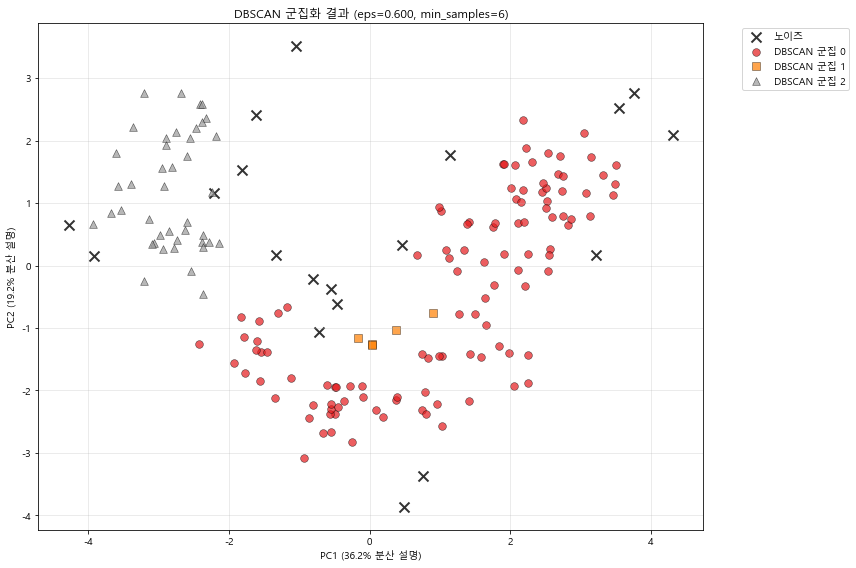

In [23]:
# DBSCAN PCA 산점도 시각화
plt.figure(figsize=(12, 8))

# 노이즈와 군집 구분
mask_noise = dbscan_labels == -1
mask_clusters = dbscan_labels != -1

# 노이즈 포인트 (검은색 X)
if mask_noise.sum() > 0:
    plt.scatter(data_pca_df.loc[mask_noise, 'PC1'], 
                data_pca_df.loc[mask_noise, 'PC2'],
                c='black', marker='x', s=100, alpha=0.8, 
                label='노이즈', linewidth=2)

# 군집 포인트 (색상별)
if mask_clusters.sum() > 0:
    unique_clusters = np.unique(dbscan_labels[mask_clusters])
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
    
    for i, cluster in enumerate(unique_clusters):
        cluster_mask = dbscan_labels == cluster
        plt.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                    data_pca_df.loc[cluster_mask, 'PC2'],
                    c=[colors[i]], 
                    marker=markers[i % len(markers)],
                    s=60, 
                    alpha=0.7,
                    label=f'DBSCAN 군집 {cluster}',
                    edgecolors='black',
                    linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title(f'DBSCAN 군집화 결과 (eps={optimal_eps:.3f}, min_samples={optimal_min_samples})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

이번에는 전 버전에 비해 노이즈는 줄었으나, 제대로 군집화가 이뤄지진 않았네요.

성능 평가 지표까지 확인을 해 봅시다

In [24]:
# DBSCAN 성능 평가
print("="*60)
print("DBSCAN 군집화 성능 평가")
print("="*60)

if n_clusters_dbscan > 1 and mask_clusters.sum() > 1:
    # 노이즈 제외하고 성능 평가
    data_for_eval = data_pca_df.values[mask_clusters]
    labels_for_eval = dbscan_labels[mask_clusters]
    
    # 실루엣 점수
    silhouette_dbscan = silhouette_score(data_for_eval, labels_for_eval)
    print(f"실루엣 점수 (Silhouette Score): {silhouette_dbscan:.4f}")
    
    # Dunn Index
    dunn_dbscan = calculate_dunn_index(data_for_eval, labels_for_eval)
    print(f"Dunn Index: {dunn_dbscan:.4f}")
    
    # DBSCAN 고유 메트릭
    print(f"\nDBSCAN 고유 특성:")
    print(f"- 노이즈 탐지율: {n_noise_dbscan/len(dbscan_labels)*100:.1f}%")
    print(f"- 유효 군집 수: {n_clusters_dbscan}개")
    
else:
    print("유효한 군집이 충분하지 않아 성능 평가를 수행할 수 없습니다.")
    silhouette_dbscan = -1
    dunn_dbscan = 0

DBSCAN 군집화 성능 평가
실루엣 점수 (Silhouette Score): 0.1597
Dunn Index: 0.2374

DBSCAN 고유 특성:
- 노이즈 탐지율: 10.7%
- 유효 군집 수: 3개


처참한 실루엣 점수가 나왔습니다.

군집 간 구별이 명확히 일어나지 않았으니 당연한 결과라고 볼 수 있겠네요

## 3. HDBSCAN

hdbscan은 dbscan을 계층적으로 변환한 버전으로, dbscan의 한계를 보완했습니다!

이 모델은 dbscan의 아쉬운 결과를 해결할 수 있을까요?

일단 그리드 서치를 통해 군집 3개를 만들면서 노이즈를 최소화하는 방향으로 하이퍼파라미터를 찾아봅시다!


### 그리드서치로 하이퍼파라미터 찾기

In [25]:
# 사용자가 원하는 클러스터 개수 지정
target_clusters = 3  # 원하는 클러스터 개수를 여기에 입력

# HDBSCAN 목표 클러스터 + 노이즈 최소화 탐색
def find_optimal_hdbscan(data, target_n_clusters, max_noise_ratio=0.3):
    min_cluster_size_range = [5, 10, 15, 20, 30]
    min_samples_range = [3, 5, 8, 10, 12]
    
    best_params = None
    best_score = -999
    
    for min_cluster_size in min_cluster_size_range:
        for min_samples in min_samples_range:
            hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, 
                                   min_samples=min_samples)
            labels = hdbscan_model.fit_predict(data)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(data)
            
            # 실용성 체크 (2개 이상 클러스터, 적당한 노이즈)
            if n_clusters >= 2 and noise_ratio <= max_noise_ratio:
                # 종합 점수 계산
                cluster_score = 1 - abs(n_clusters - target_n_clusters) / target_n_clusters
                noise_score = 1 - noise_ratio
                
                # 실루엣 점수
                mask = labels != -1
                if mask.sum() > 1:
                    try:
                        sil_score = silhouette_score(data[mask], labels[mask])
                        sil_score = max(0, sil_score)
                    except:
                        sil_score = 0
                else:
                    sil_score = 0
                
                # 종합 점수 (목표 클러스터: 40%, 노이즈 최소화: 40%, 실루엣: 20%)
                combined_score = cluster_score * 0.4 + noise_score * 0.4 + sil_score * 0.2
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_params = (min_cluster_size, min_samples, n_clusters, noise_ratio, sil_score, combined_score)
    
    return best_params

# 최적 파라미터 찾기
result = find_optimal_hdbscan(data_pca_df[['PC1', 'PC2']].values, target_clusters, max_noise_ratio=0.3)

if result:
    optimal_min_cluster_size, optimal_min_samples, found_clusters, noise_ratio, sil_score, combined_score = result
    print(f"목표: {target_clusters}개 클러스터, 낮은 노이즈")
    print(f"결과: {found_clusters}개 클러스터, 노이즈 {noise_ratio*100:.1f}%, 종합점수 {combined_score:.3f}")
else:
    # 조건 완화하여 재시도
    result = find_optimal_hdbscan(data_pca_df[['PC1', 'PC2']].values, target_clusters, max_noise_ratio=0.5)
    if result:
        optimal_min_cluster_size, optimal_min_samples, found_clusters, noise_ratio, sil_score, combined_score = result
        print(f"조건 완화 결과: {found_clusters}개 클러스터, 노이즈 {noise_ratio*100:.1f}%")
    else:
        optimal_min_cluster_size, optimal_min_samples = 10, 5
        print("적절한 파라미터를 찾지 못해 기본값 사용")

# HDBSCAN 군집화
hdbscan_optimal = HDBSCAN(min_cluster_size=optimal_min_cluster_size, 
                         min_samples=optimal_min_samples)
hdbscan_labels = hdbscan_optimal.fit_predict(data_pca_df[['PC1', 'PC2']].values)

# 결과 분석
n_clusters_hdbscan = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise_hdbscan = list(hdbscan_labels).count(-1)

# 군집별 분포
unique_labels_hdb, counts_hdb = np.unique(hdbscan_labels, return_counts=True)
for label, count in zip(unique_labels_hdb, counts_hdb):
    if label == -1:
        print(f"  노이즈: {count}개")
    else:
        print(f"  군집 {label}: {count}개")

# 결과 저장
data_pca_df['hdbscan_cluster'] = hdbscan_labels
data_clean['hdbscan_cluster'] = hdbscan_labels

목표: 3개 클러스터, 낮은 노이즈
결과: 3개 클러스터, 노이즈 13.5%, 종합점수 0.857
  노이즈: 24개
  군집 0: 44개
  군집 1: 39개
  군집 2: 71개


오! 일단 군집 개수가 dbscan에 비해 균일한 편이네요! 이정도면 아까보단 나은 모델일 가능성이 높아보입니다

### 산점도 시각화

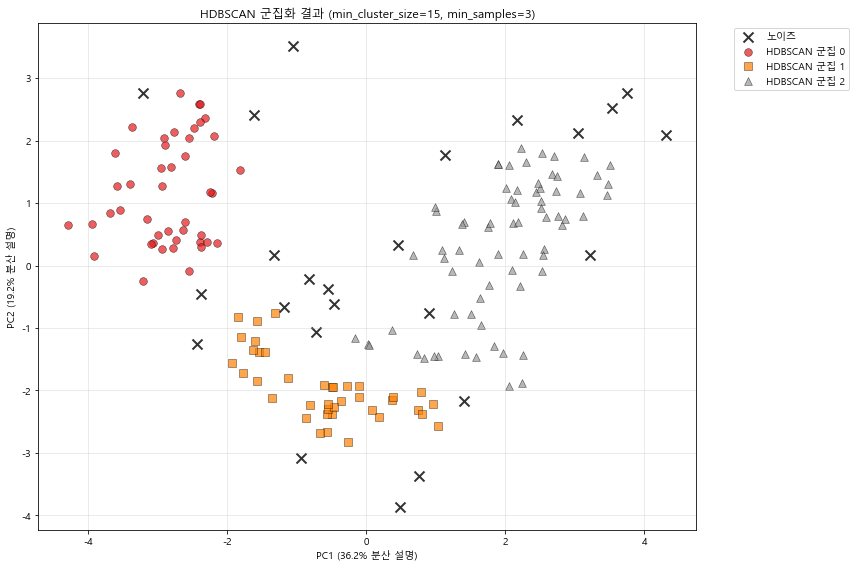

In [26]:
# HDBSCAN PCA 산점도 시각화
plt.figure(figsize=(12, 8))

# 노이즈와 군집 구분
mask_noise = hdbscan_labels == -1
mask_clusters = hdbscan_labels != -1

# 노이즈 포인트 (검은색 X)
if mask_noise.sum() > 0:
    plt.scatter(data_pca_df.loc[mask_noise, 'PC1'], 
                data_pca_df.loc[mask_noise, 'PC2'],
                c='black', marker='x', s=100, alpha=0.8, 
                label='노이즈', linewidth=2)

# 군집 포인트 (색상별)
if mask_clusters.sum() > 0:
    unique_clusters = np.unique(hdbscan_labels[mask_clusters])
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
    
    for i, cluster in enumerate(unique_clusters):
        cluster_mask = hdbscan_labels == cluster
        plt.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                    data_pca_df.loc[cluster_mask, 'PC2'],
                    c=[colors[i]], 
                    marker=markers[i % len(markers)],
                    s=60, 
                    alpha=0.7,
                    label=f'HDBSCAN 군집 {cluster}',
                    edgecolors='black',
                    linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title(f'HDBSCAN 군집화 결과 (min_cluster_size={optimal_min_cluster_size}, min_samples={optimal_min_samples})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

비교적 잘 나눠져 있지만, 정답을 아는 우리의 입장에서는 군집 1과 군집 2을 명확히 구분하지 못했다는 점을 알 수 있어요

### 군집화 성능 평가지표

In [27]:
# HDBSCAN 성능 평가
print("="*60)
print("HDBSCAN 군집화 성능 평가")
print("="*60)

if n_clusters_hdbscan > 1 and mask_clusters.sum() > 1:
    # 노이즈 제외하고 성능 평가
    data_for_eval = data_pca_df.values[mask_clusters]
    labels_for_eval = hdbscan_labels[mask_clusters]
    
    # 실루엣 점수
    silhouette_hdbscan = silhouette_score(data_for_eval, labels_for_eval)
    print(f"실루엣 점수 (Silhouette Score): {silhouette_hdbscan:.4f}")
    
    # Dunn Index
    dunn_hdbscan = calculate_dunn_index(data_for_eval, labels_for_eval)
    print(f"Dunn Index: {dunn_hdbscan:.4f}")
    
    # HDBSCAN 고유 메트릭
    print(f"\nHDBSCAN 고유 특성:")
    print(f"- 노이즈 탐지율: {n_noise_hdbscan/len(hdbscan_labels)*100:.1f}%")
    print(f"- 유효 군집 수: {n_clusters_hdbscan}개")
    
    # 클러스터 지속성 점수 (cluster persistence scores)
    if hasattr(hdbscan_optimal, 'cluster_persistence_'):
        print(f"- 평균 클러스터 지속성: {np.mean(hdbscan_optimal.cluster_persistence_):.4f}")


HDBSCAN 군집화 성능 평가
실루엣 점수 (Silhouette Score): 0.5700
Dunn Index: 0.6151

HDBSCAN 고유 특성:
- 노이즈 탐지율: 13.5%
- 유효 군집 수: 3개
- 평균 클러스터 지속성: 0.2361


꽤나 준수한 결과를 얻었습니다만, k-means에 비해서는 결과가 아쉬운 편이네요

마지막으로 GMM을 활용해보겠습니다!

## 4. GMM

### 그리드서치

In [28]:
# 사용자가 원하는 클러스터 개수 지정
target_clusters = 3  # 원하는 클러스터 개수를 여기에 입력

# GMM 목표 클러스터 개수 탐색
def find_optimal_gmm(data, target_n_clusters):
    n_components_range = [2, 3, 4, 5, 6, 7, 8]
    covariance_type_range = ['full', 'tied', 'diag', 'spherical']
    
    best_params = None
    best_score = -999
    
    for n_components in n_components_range:
        for covariance_type in covariance_type_range:
            try:
                gmm = GaussianMixture(n_components=n_components, 
                                    covariance_type=covariance_type,
                                    random_state=42)
                labels = gmm.fit_predict(data)
                
                # 클러스터 목표와의 차이
                cluster_diff = abs(n_components - target_n_clusters)
                
                # 실루엣 점수
                if n_components > 1:
                    try:
                        sil_score = silhouette_score(data, labels)
                    except:
                        sil_score = -1
                else:
                    sil_score = -1
                
                # AIC, BIC (낮을수록 좋음)
                aic_score = gmm.aic(data)
                bic_score = gmm.bic(data)
                
                # 종합 점수 계산
                cluster_score = 1 - cluster_diff / target_n_clusters  # 목표에 가까울수록 높음
                silhouette_score_norm = max(0, sil_score)  # 음수면 0으로
                
                # GMM은 AIC/BIC가 중요하므로 가중치 조정
                combined_score = (
                    cluster_score * 0.5 +       # 목표 클러스터 50%
                    silhouette_score_norm * 0.3 + # 실루엣 30%
                    (1 / (1 + bic_score / 1000)) * 0.2  # BIC 20% (정규화)
                )
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_params = (n_components, covariance_type, sil_score, aic_score, bic_score, combined_score)
                    
            except Exception as e:
                continue
    
    return best_params

# 최적 파라미터 찾기
result = find_optimal_gmm(data_pca_df[['PC1', 'PC2']].values, target_clusters)

if result:
    optimal_n_components, optimal_covariance_type, sil_score, aic_score, bic_score, combined_score = result
    print(f"목표: {target_clusters}개 클러스터")
    print(f"결과: {optimal_n_components}개 클러스터, 공분산타입: {optimal_covariance_type}")
else:
    optimal_n_components, optimal_covariance_type = 3, 'full'
    print("적절한 파라미터를 찾지 못해 기본값 사용")

목표: 3개 클러스터
결과: 3개 클러스터, 공분산타입: diag


### (참고) GMM의 공붕산 타입 설명

GMM(Gaussian Mixture Model)의 그리드서치에 사용되는 공분산(covariance) 타입은 모델이 각 군집의 모양을 어떻게 가정하는지에 대한 설정입니다. 아래 표는 네 가지 주요 공분산 타입에 대한 간단한 설명입니다.

| 공분산 타입 | 설명 |
|:--- |:--- |
| **`full`** | 각 군집이 고유한 타원형 모양을 가질 수 있습니다. 가장 유연하고 복잡한 모델로, 모든 변수 간의 상관관계를 고려합니다. |
| **`tied`** | 모든 군집이 동일한 타원형 모양을 가집니다. 즉, 모든 군집이 동일한 공분산 행렬을 공유합니다. `full` 타입보다 자유도가 낮습니다. |
| **`diag`** | 각 군집의 축이 데이터의 축과 평행한 타원형 모양을 가집니다. 변수 간의 상관관계는 고려하지 않고, 각 변수의 분산만 다르게 설정할 수 있습니다. |
| **`spherical`** | 각 군집이 원형 모양을 가집니다. 모든 변수의 분산이 동일하다고 가정합니다. 가장 단순하고 제한적인 모델입니다. |

### 군집화 시행

In [29]:
# GMM 군집화
gmm_optimal = GaussianMixture(n_components=optimal_n_components, 
                             covariance_type=optimal_covariance_type,
                             random_state=42)
gmm_labels = gmm_optimal.fit_predict(data_pca_df[['PC1', 'PC2']].values)

# 결과 분석
n_clusters_gmm = optimal_n_components

# 군집별 분포
unique_labels_gmm, counts_gmm = np.unique(gmm_labels, return_counts=True)
for label, count in zip(unique_labels_gmm, counts_gmm):
    print(f"  군집 {label}: {count}개")

# 결과 저장
data_pca_df['gmm_cluster'] = gmm_labels
data_clean['gmm_cluster'] = gmm_labels

  군집 0: 68개
  군집 1: 49개
  군집 2: 61개


굉장히 고른 숫자로 군집이 형성되었음을 알 수 있었습니다!

### 산점도 시각화

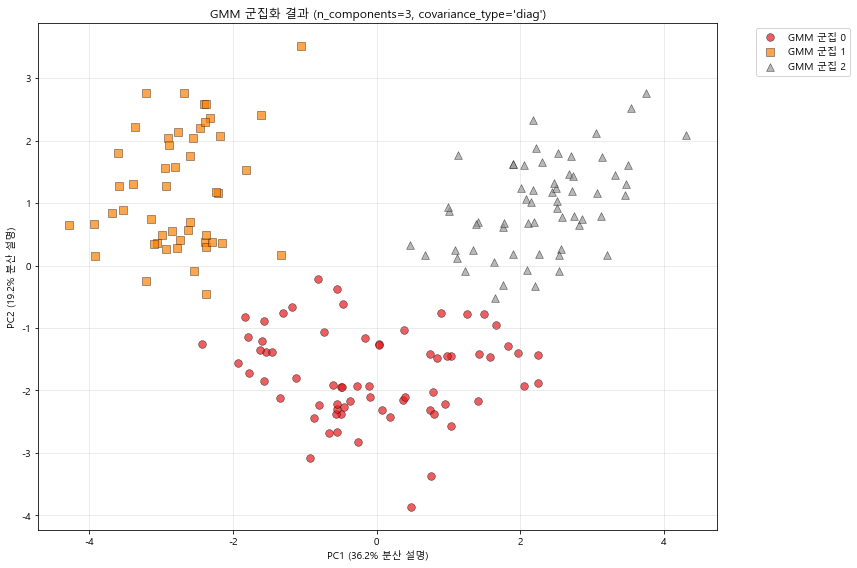

In [30]:
# GMM PCA 산점도 시각화
plt.figure(figsize=(12, 8))

# 군집 포인트 (색상별)
unique_clusters = np.unique(gmm_labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

for i, cluster in enumerate(unique_clusters):
    cluster_mask = gmm_labels == cluster
    plt.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                data_pca_df.loc[cluster_mask, 'PC2'],
                c=[colors[i]], 
                marker=markers[i % len(markers)],
                s=60, 
                alpha=0.7,
                label=f'GMM 군집 {cluster}',
                edgecolors='black',
                linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
plt.title(f'GMM 군집화 결과 (n_components={optimal_n_components}, covariance_type=\'{optimal_covariance_type}\')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

와! 정말 군집화가 잘 된 것으로 보이네요! 마지막으로 성능 평가 지표까지 찍어봅시다!

### 성능 평가

In [31]:
# GMM 성능 평가
print("="*60)
print("GMM 군집화 성능 평가")
print("="*60)

if n_clusters_gmm > 1:
    # 학습에 사용한 데이터와 동일한 특성 사용 (GMM 학습시 사용한 데이터)
    eval_data = data_pca_df[['PC1', 'PC2']].values
    
    # 실루엣 점수
    silhouette_gmm = silhouette_score(eval_data, gmm_labels)
    print(f"실루엣 점수 (Silhouette Score): {silhouette_gmm:.4f}")
    
    # Dunn Index
    dunn_gmm = calculate_dunn_index(eval_data, gmm_labels)
    print(f"Dunn Index: {dunn_gmm:.4f}")
    
    # GMM 고유 메트릭 - 학습된 모델의 정보만 출력 (재계산 방지)
    print(f"\nGMM 고유 특성:")
    try:
        print(f"- AIC (Akaike Information Criterion): {gmm_optimal.aic(eval_data):.2f}")
        print(f"- BIC (Bayesian Information Criterion): {gmm_optimal.bic(eval_data):.2f}")
        print(f"- Log-likelihood: {gmm_optimal.score(eval_data):.2f}")
    except:
        print("- AIC/BIC/Log-likelihood: 계산 불가 (차원 불일치)")
    
    print(f"- 군집 수: {n_clusters_gmm}개")
    
    # 각 군집의 확률 분포 정보
    print(f"\n군집별 가중치 (mixing coefficients):")
    for i, weight in enumerate(gmm_optimal.weights_):
        print(f"  군집 {i}: {weight:.4f}")
    
    
else:
    print("유효한 군집이 충분하지 않아 성능 평가를 수행할 수 없습니다.")
    silhouette_gmm = -1
    dunn_gmm = 0

GMM 군집화 성능 평가
실루엣 점수 (Silhouette Score): 0.5615
Dunn Index: 0.6273

GMM 고유 특성:
- AIC (Akaike Information Criterion): 1274.87
- BIC (Bayesian Information Criterion): 1319.41
- Log-likelihood: -3.50
- 군집 수: 3개

군집별 가중치 (mixing coefficients):
  군집 0: 0.3878
  군집 1: 0.2771
  군집 2: 0.3351


꽤나 준수한 성능이 나왔음을 알 수 있어요

다만 어떤 모델이 가장 적합한지는 아직까진 잘 모르겠어요...

그러니 모든 모델의 결과를 모아서 비교해봅시다!

# 3. 전체 모델 비교

## 전체 모델 산점도 비교

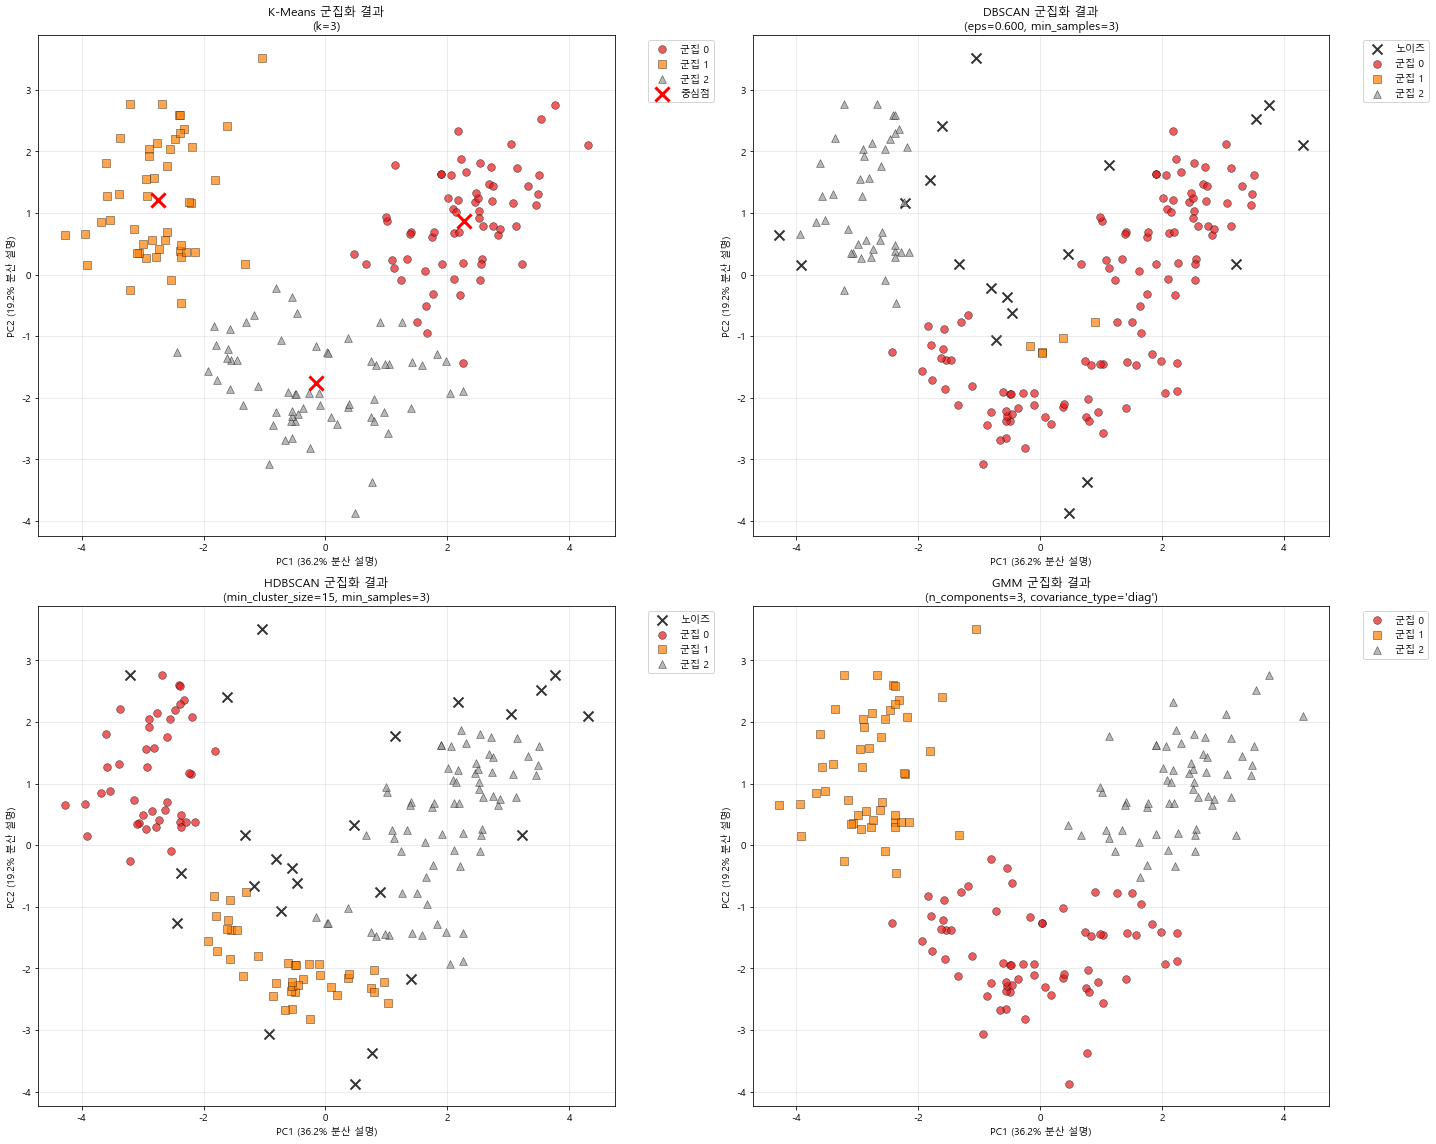

In [32]:
# 전체 모델 산점도 비교
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

models = [
    ('K-Means', 'kmeans_cluster', f'k={optimal_k}'),
    ('DBSCAN', 'dbscan_cluster', f'eps={optimal_eps:.3f}, min_samples={optimal_min_samples}'),
    ('HDBSCAN', 'hdbscan_cluster', f'min_cluster_size={optimal_min_cluster_size}, min_samples={optimal_min_samples}'),
    ('GMM', 'gmm_cluster', f'n_components={optimal_n_components}, covariance_type=\'{optimal_covariance_type}\'')
    
]

for idx, (model_name, cluster_col, params) in enumerate(models):
    ax = axes[idx]
    
    if cluster_col in data_pca_df.columns:
        labels = data_pca_df[cluster_col].values
        
        # 노이즈 처리 (DBSCAN, HDBSCAN의 경우)
        if model_name in ['DBSCAN', 'HDBSCAN']:
            mask_noise = labels == -1
            mask_clusters = labels != -1
            
            # 노이즈 포인트
            if mask_noise.sum() > 0:
                ax.scatter(data_pca_df.loc[mask_noise, 'PC1'], 
                          data_pca_df.loc[mask_noise, 'PC2'],
                          c='black', marker='x', s=100, alpha=0.8, 
                          label='노이즈', linewidth=2)
            
            # 군집 포인트
            if mask_clusters.sum() > 0:
                unique_clusters = np.unique(labels[mask_clusters])
            else:
                unique_clusters = []
        else:
            unique_clusters = np.unique(labels)
            mask_clusters = np.ones(len(labels), dtype=bool)
        
        # 군집별 색상 및 마커
        if len(unique_clusters) > 0:
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_clusters)))
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']
            
            for i, cluster in enumerate(unique_clusters):
                cluster_mask = labels == cluster
                ax.scatter(data_pca_df.loc[cluster_mask, 'PC1'], 
                          data_pca_df.loc[cluster_mask, 'PC2'],
                          c=[colors[i]], 
                          marker=markers[i % len(markers)],
                          s=60, 
                          alpha=0.7,
                          label=f'군집 {cluster}',
                          edgecolors='black',
                          linewidth=0.5)
        
        # K-Means의 경우 중심점 표시
        if model_name == 'K-Means' and 'kmeans' in locals():
            centers_pca = kmeans.cluster_centers_
            ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                      c='red', marker='x', s=200, linewidth=3, 
                      label='중심점')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% 분산 설명)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% 분산 설명)')
        ax.set_title(f'{model_name} 군집화 결과\n({params})')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, f'{model_name}\n데이터 없음', 
                ha='center', va='center', transform=ax.transAxes,
                fontsize=16)
        ax.set_title(f'{model_name} - 데이터 없음')

plt.tight_layout()
plt.show()

실제 라벨과 비교했을때 어떤 군집화 방식이 적절했고, 어떤 군집화 방식이 부적절했는지 적어봅시다!

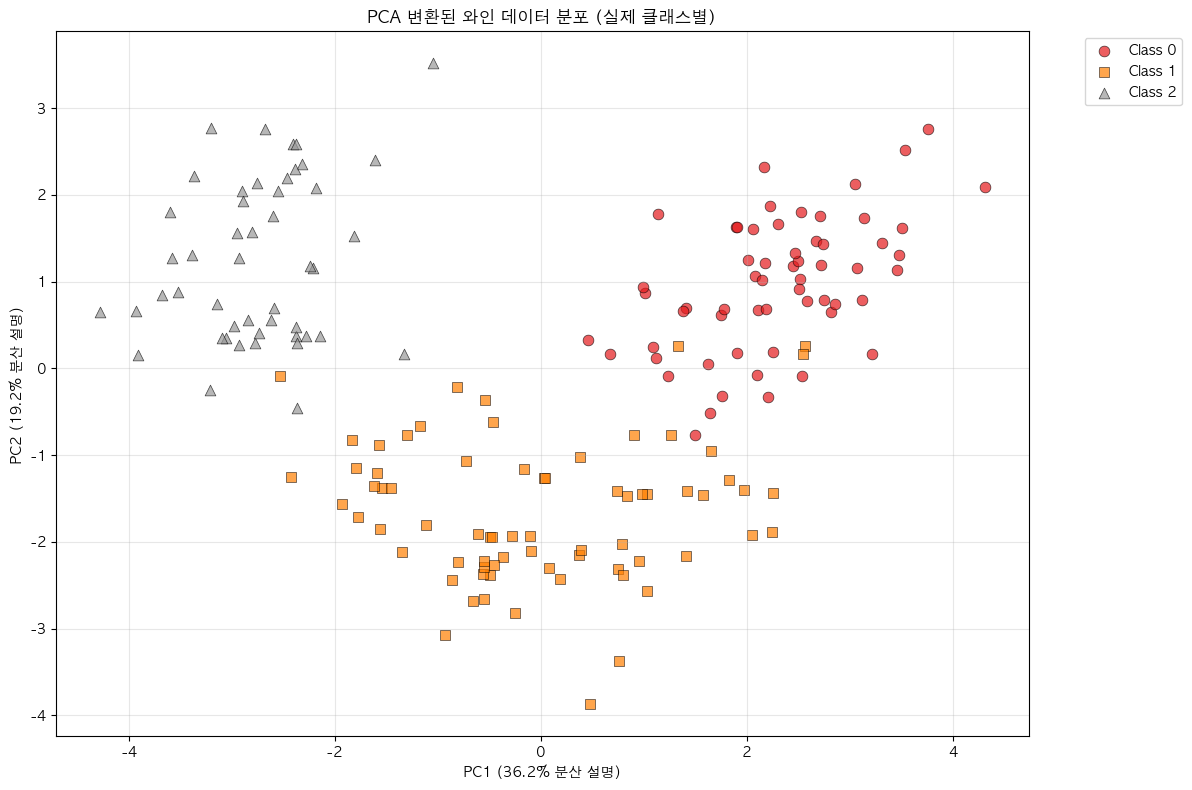

적합한 군집화 모델(얼추 비슷한 형상) : k-means, GMM

부적합한 군집화 모델(어림없는 형상) : DBSCAN, HDBSCAN

## 전체 모델 성능 평가 지표 비교

방금은 산점도를 통해 시각적으로 군집화의 적절성을 판별했었는데, 이는 엄밀하지 않은 방법입니다

확실하게 하려면 정답과 군집화 결과를 비교하면 되는데, 다행히 우리가 사용한 와인 데이터는 정답 라벨이 있었습니다!

우리는 이 정답 라벨과 군집화 결과를 비교함으로서, 군집화의 성능을 명확히 표시할 수 있습니다

In [33]:
# 전체 모델 성능 비교 분석 (노이즈 오답 처리 버전)
def calculate_clustering_accuracy(true_labels, cluster_labels):
    """헝가리안 알고리즘을 사용한 군집화 정확도 계산 (노이즈는 오답 처리)"""
    total_samples = len(true_labels)
    
    # 노이즈가 있는 경우 처리
    if -1 in cluster_labels:
        # 노이즈가 아닌 데이터만 추출
        valid_mask = cluster_labels != -1
        n_noise = (cluster_labels == -1).sum()
        
        if valid_mask.sum() == 0:
            # 모든 데이터가 노이즈면 정확도 0
            return 0.0, 0, total_samples, n_noise
        
        true_labels_valid = true_labels[valid_mask]
        cluster_labels_valid = cluster_labels[valid_mask]
    else:
        true_labels_valid = true_labels
        cluster_labels_valid = cluster_labels
        n_noise = 0
    
    # 헝가리안 알고리즘으로 최적 매칭
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels_valid, cluster_labels_valid)
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # 올바르게 분류된 개수
    correct = cm[row_ind, col_ind].sum()
    
    # 전체 정확도 = 올바른 분류 / 전체 데이터 (노이즈 포함)
    accuracy = correct / total_samples
    
    return accuracy, correct, total_samples, n_noise

# 모델별 성능 평가
models = [
    ('K-Means', 'kmeans_cluster'),
    ('DBSCAN', 'dbscan_cluster'), 
    ('HDBSCAN', 'hdbscan_cluster'),
    ('GMM', 'gmm_cluster')
]

results = []
print("=" * 80)
print("전체 모델 성능 비교 (노이즈는 오답 처리)")
print("=" * 80)

for model_name, cluster_col in models:
    if cluster_col in data_pca_df.columns:
        labels = data_pca_df[cluster_col].values
        
        # 정확도 계산 (노이즈는 오답 처리)
        accuracy, correct, total, n_noise = calculate_clustering_accuracy(true_classes, labels)
        
        # 실루엣 점수 (노이즈 제외하고 계산)
        if model_name in ['DBSCAN', 'HDBSCAN']:
            mask = labels != -1
            if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
                sil_score = silhouette_score(data_pca_df[['PC1', 'PC2']].values[mask], labels[mask])
            else:
                sil_score = -1
        else:
            if len(np.unique(labels)) > 1:
                sil_score = silhouette_score(data_pca_df[['PC1', 'PC2']].values, labels)
            else:
                sil_score = -1
        
        # Dunn Index (노이즈 제외하고 계산)
        if model_name in ['DBSCAN', 'HDBSCAN']:
            mask = labels != -1
            if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
                dunn_score = calculate_dunn_index(data_pca_df[['PC1', 'PC2']].values[mask], labels[mask])
            else:
                dunn_score = 0
        else:
            dunn_score = calculate_dunn_index(data_pca_df[['PC1', 'PC2']].values, labels)
    
        
        # 클러스터 수
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Silhouette': sil_score,
            'Dunn_Index': dunn_score,
            'N_Clusters': n_clusters,
            'Noise_Count': n_noise
        })
        
        print(f"{model_name}:")
        print(f"  정확도: {accuracy:.3f} ({correct}/{total})")
        if n_noise > 0:
            print(f"  노이즈: {n_noise}개 (오답 처리)")
        print(f"  실루엣 점수: {sil_score:.4f}")
        print(f"  Dunn Index: {dunn_score:.4f}")
        print()

전체 모델 성능 비교 (노이즈는 오답 처리)
K-Means:
  정확도: 0.966 (172/178)
  실루엣 점수: 0.5611
  Dunn Index: 0.6267

DBSCAN:
  정확도: 0.562 (100/178)
  노이즈: 19개 (오답 처리)
  실루엣 점수: 0.0749
  Dunn Index: 0.1431

HDBSCAN:
  정확도: 0.747 (133/178)
  노이즈: 24개 (오답 처리)
  실루엣 점수: 0.5568
  Dunn Index: 0.6629

GMM:
  정확도: 0.972 (173/178)
  실루엣 점수: 0.5615
  Dunn Index: 0.6273



In [34]:
results_df = pd.DataFrame(results)

results_df

,Model,Accuracy,Silhouette,Dunn_Index,N_Clusters,Noise_Count
0,K-Means,0.966292,0.561051,0.626668,3,0
1,DBSCAN,0.561798,0.074878,0.143110,3,19
2,HDBSCAN,0.747191,0.556817,0.662908,3,24
3,GMM,0.971910,0.561524,0.627347,3,0


## 가장 좋은 모델 : GMM

## 군집별 특성 정답 라벨과 비교하기

아래는 우리가 군집으로 만든 군집들의 피처 특성을 박스플롯을 통해 찍고, 이를 정답과 비교할 수 있는 코드입니다!

원하는 모델 명을 입력하고, 특성을 비교해보세요!

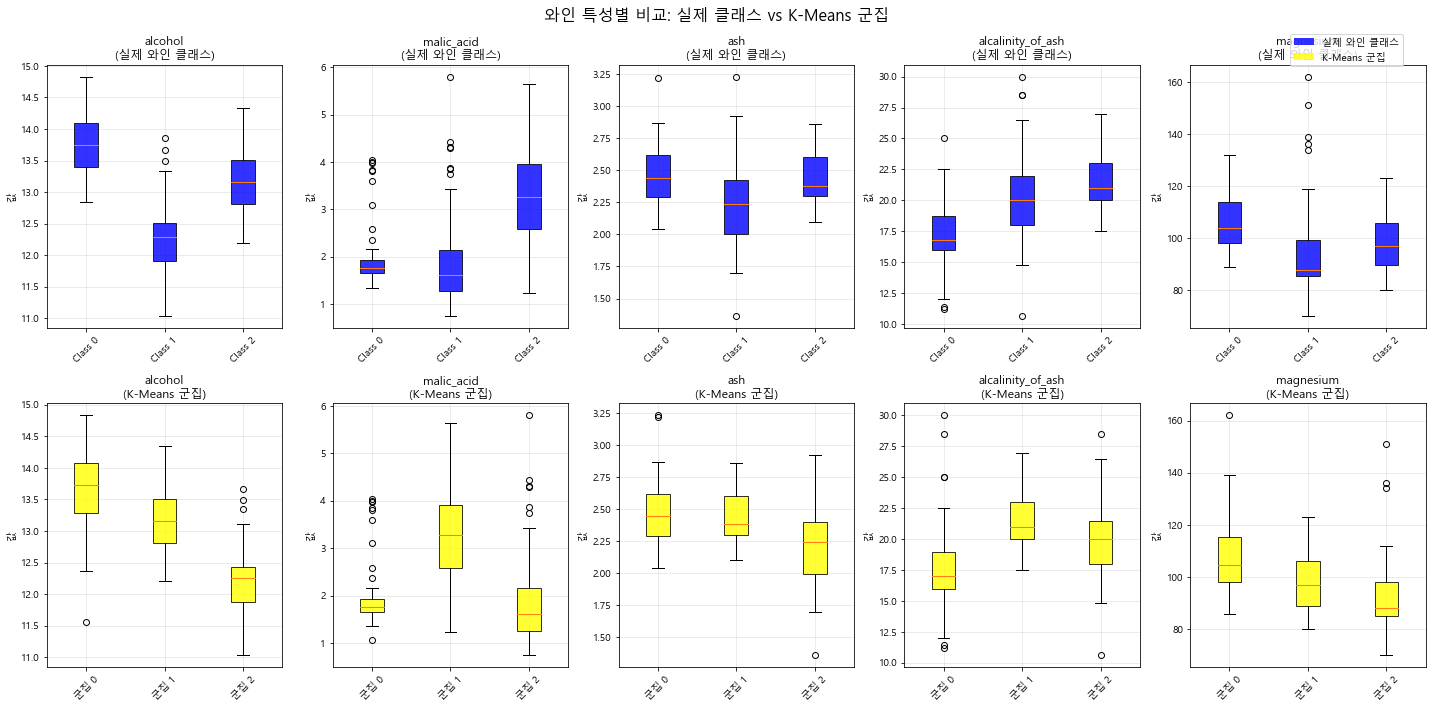


K-Means 혼동 행렬:


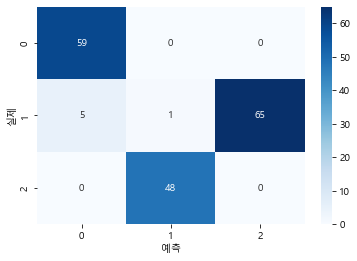

In [40]:
#검증하고싶은 모델 입력
selected_model = 'K-Means' # 'K-Means', 'DBSCAN', 'HDBSCAN', 'GMM' 중 원하는 모델 입력


model_mapping = {
    'K-Means': 'kmeans_cluster',
    'DBSCAN': 'dbscan_cluster', 
    'HDBSCAN': 'hdbscan_cluster',
    'GMM': 'gmm_cluster'
}

if selected_model not in model_mapping:
    selected_model = 'K-Means'

cluster_col = model_mapping[selected_model]

if cluster_col in data_pca_df.columns:
    selected_cluster_labels = data_pca_df[cluster_col]
    
    # 8개 특성 선택
    features_to_plot = wine.feature_names[:5]
    
    # 2행 구조로 시각화 (1행: 정답, 2행: 예측)
    fig, axes = plt.subplots(nrows=2, ncols=len(features_to_plot), 
                            figsize=(4*len(features_to_plot), 10))
    
    for i, feature in enumerate(features_to_plot):
        # 1행: 정답 클래스별 박스플롯 (파란색)
        ax_true = axes[0, i]
        true_data = []
        true_labels = []
        
        for true_class in sorted(np.unique(true_classes)):
            mask = true_classes == true_class
            true_data.append(data.loc[mask, feature].values)
            true_labels.append(f'{class_names[true_class]}')
        
        bp_true = ax_true.boxplot(true_data, labels=true_labels, patch_artist=True)
        for patch in bp_true['boxes']:
            patch.set_facecolor('blue')
            patch.set_alpha(0.8)
        
        ax_true.set_title(f'{feature}\n(실제 와인 클래스)')
        ax_true.set_ylabel('값')
        ax_true.tick_params(axis='x', rotation=45)
        ax_true.grid(True, alpha=0.3)
        
        # 2행: 예측 군집별 박스플롯 (주황색)
        ax_pred = axes[1, i]
        pred_data = []
        pred_labels = []
        
        unique_pred = np.unique(selected_cluster_labels)
        for pred_label in sorted(unique_pred):
            if pred_label != -1:  # 노이즈 제외
                mask = selected_cluster_labels == pred_label
                if mask.sum() > 0:
                    pred_data.append(data.loc[mask, feature].values)
                    pred_labels.append(f'군집 {pred_label}')
        
        if pred_data:  # 예측 데이터가 있는 경우만
            bp_pred = ax_pred.boxplot(pred_data, labels=pred_labels, patch_artist=True)
            for patch in bp_pred['boxes']:
                patch.set_facecolor('yellow')
                patch.set_alpha(0.8)
        
        ax_pred.set_title(f'{feature}\n({selected_model} 군집)')
        ax_pred.set_ylabel('값')
        ax_pred.tick_params(axis='x', rotation=45)
        ax_pred.grid(True, alpha=0.3)
        
        # y축 범위 통일 (비교 용이성)
        y_min = min(ax_true.get_ylim()[0], ax_pred.get_ylim()[0])
        y_max = max(ax_true.get_ylim()[1], ax_pred.get_ylim()[1])
        ax_true.set_ylim(y_min, y_max)
        ax_pred.set_ylim(y_min, y_max)
    
    # 전체 제목과 범례
    fig.suptitle(f'와인 특성별 비교: 실제 클래스 vs {selected_model} 군집', 
                 fontsize=16, y=0.98)
    
    # 범례 추가
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.8, label='실제 와인 클래스'),
        Patch(facecolor='yellow', alpha=0.8, label=f'{selected_model} 군집')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # 혼동 행렬
    print(f"\n{selected_model} 혼동 행렬:")
    confusion_df = pd.crosstab(true_classes, selected_cluster_labels, 
                              rownames=['실제'], colnames=['예측'], margins=True)
    sns.heatmap(confusion_df.iloc[:-1,:-1], cmap='Blues', annot=True)
    
else:
    print(f"{selected_model} 결과를 찾을 수 없습니다.")

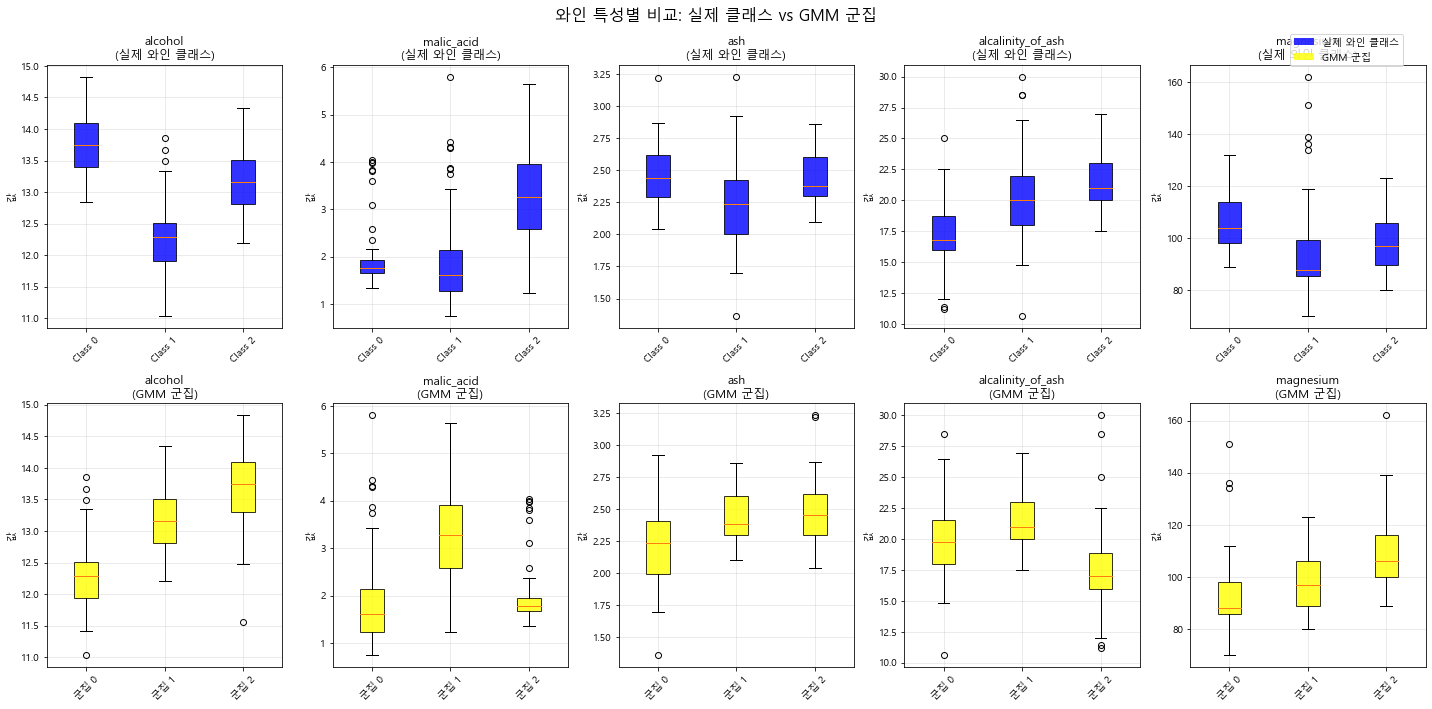


GMM 혼동 행렬:


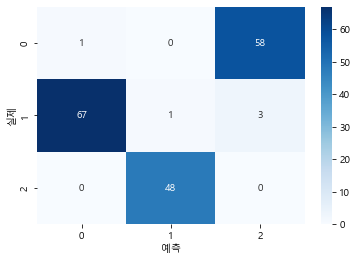

In [41]:
#검증하고싶은 모델 입력
selected_model = 'GMM' # 'K-Means', 'DBSCAN', 'HDBSCAN', 'GMM' 중 원하는 모델 입력


model_mapping = {
    'K-Means': 'kmeans_cluster',
    'DBSCAN': 'dbscan_cluster', 
    'HDBSCAN': 'hdbscan_cluster',
    'GMM': 'gmm_cluster'
}

if selected_model not in model_mapping:
    selected_model = 'K-Means'

cluster_col = model_mapping[selected_model]

if cluster_col in data_pca_df.columns:
    selected_cluster_labels = data_pca_df[cluster_col]
    
    # 8개 특성 선택
    features_to_plot = wine.feature_names[:5]
    
    # 2행 구조로 시각화 (1행: 정답, 2행: 예측)
    fig, axes = plt.subplots(nrows=2, ncols=len(features_to_plot), 
                            figsize=(4*len(features_to_plot), 10))
    
    for i, feature in enumerate(features_to_plot):
        # 1행: 정답 클래스별 박스플롯 (파란색)
        ax_true = axes[0, i]
        true_data = []
        true_labels = []
        
        for true_class in sorted(np.unique(true_classes)):
            mask = true_classes == true_class
            true_data.append(data.loc[mask, feature].values)
            true_labels.append(f'{class_names[true_class]}')
        
        bp_true = ax_true.boxplot(true_data, labels=true_labels, patch_artist=True)
        for patch in bp_true['boxes']:
            patch.set_facecolor('blue')
            patch.set_alpha(0.8)
        
        ax_true.set_title(f'{feature}\n(실제 와인 클래스)')
        ax_true.set_ylabel('값')
        ax_true.tick_params(axis='x', rotation=45)
        ax_true.grid(True, alpha=0.3)
        
        # 2행: 예측 군집별 박스플롯 (주황색)
        ax_pred = axes[1, i]
        pred_data = []
        pred_labels = []
        
        unique_pred = np.unique(selected_cluster_labels)
        for pred_label in sorted(unique_pred):
            if pred_label != -1:  # 노이즈 제외
                mask = selected_cluster_labels == pred_label
                if mask.sum() > 0:
                    pred_data.append(data.loc[mask, feature].values)
                    pred_labels.append(f'군집 {pred_label}')
        
        if pred_data:  # 예측 데이터가 있는 경우만
            bp_pred = ax_pred.boxplot(pred_data, labels=pred_labels, patch_artist=True)
            for patch in bp_pred['boxes']:
                patch.set_facecolor('yellow')
                patch.set_alpha(0.8)
        
        ax_pred.set_title(f'{feature}\n({selected_model} 군집)')
        ax_pred.set_ylabel('값')
        ax_pred.tick_params(axis='x', rotation=45)
        ax_pred.grid(True, alpha=0.3)
        
        # y축 범위 통일 (비교 용이성)
        y_min = min(ax_true.get_ylim()[0], ax_pred.get_ylim()[0])
        y_max = max(ax_true.get_ylim()[1], ax_pred.get_ylim()[1])
        ax_true.set_ylim(y_min, y_max)
        ax_pred.set_ylim(y_min, y_max)
    
    # 전체 제목과 범례
    fig.suptitle(f'와인 특성별 비교: 실제 클래스 vs {selected_model} 군집', 
                 fontsize=16, y=0.98)
    
    # 범례 추가
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.8, label='실제 와인 클래스'),
        Patch(facecolor='yellow', alpha=0.8, label=f'{selected_model} 군집')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # 혼동 행렬
    print(f"\n{selected_model} 혼동 행렬:")
    confusion_df = pd.crosstab(true_classes, selected_cluster_labels, 
                              rownames=['실제'], colnames=['예측'], margins=True)
    sns.heatmap(confusion_df.iloc[:-1,:-1], cmap='Blues', annot=True)
    
else:
    print(f"{selected_model} 결과를 찾을 수 없습니다.")

In [42]:
#군집 라벨 번호가 달라진 것을 제외하고 생각하면,
#k-means는 6개의 오류, GMM은 5개의 오류가 있다.

# 마무리

본 군집화 과제를 통해 새롭게 알게 된 부분을 자유롭게 정리해주세요(최소 3개)

1. DBSCAN은 밀도가 약한 부분을 노이즈로 처리하는 경향이 있기 때문에 파라미터를 설정하고 바꿔보는 것이 중요하다.  
2. 평가지표가 좋게 나왔을 때에도 노이즈 처리된 포인트들의 수와 분포를 확인해 보아야 한다.  
3. 박스플롯을 통해 확인해 보니, 이상치들은 잘못된 군집에 위치할 가능성이 높다.(정답라벨이 없을 경우 이상치에는 특히 유의해야 한다.)

수고하셨습니다~